# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.10 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])
print('The state for the second agent looks like:', states[1])
#print(states)

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]
The state for the second agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.4669857  -1.5         0.          0.
 -6.83172083  6.          0.          0.        ]


### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [5]:
from maddpg import MADDPGAgents

agent0_weights_actor = "agent0_weights_actor.pth"
agent0_weights_critic = "agent0_weights_critic.pth"
agent1_weights_actor = "agent1_weights_actor.pth"
agent1_weights_critic = "agent1_weights_critic.pth"

agents = MADDPGAgents(state_size=state_size, action_size=action_size, num_agents=num_agents, random_seed=0)

Episode 100	Score: 0.00000	Average score: 0.01740
Episode 200	Score: 0.00000	Average score: 0.01950
Episode 300	Score: 0.10000	Average score: 0.00800
Episode 400	Score: 0.00000	Average score: 0.03100
Episode 500	Score: 0.10000	Average score: 0.07170
Episode 600	Score: 0.00000	Average score: 0.11970
Episode 700	Score: 0.10000	Average score: 0.43080
Episode 753	Score: 2.60000	Average score: 0.51390

Environment solved in 753 episodes!	Average score: 0.51390


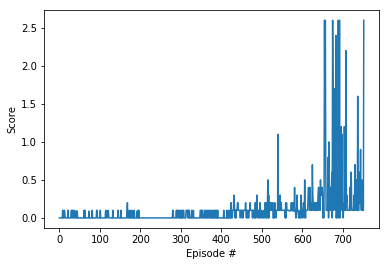

In [6]:
from collections import deque
import matplotlib.pyplot as plt
import torch
import workspace_utils as wu

%matplotlib inline

def train_maddpg(environment, agents, agent0_weights_actor, agent0_weights_critic, \
                 agent1_weights_actor, agent1_weights_critic, n_episodes=2000):
    """Mutli Agent Deep Deterministic Policy Gradient Learning for the given agent in the given environment.

    Params
    ======
        environment (UnityEnvironment): environment
        agents (MADDPGAgents): MADDPGAgents object representing the parallel agents
        agent0_weights_actor (str): file containing the weights for the actor for agent0
        agent0_weights_critic (str): file containing the weights for the critic for agent0
        agent1_weights_actor (str): file containing the weights for the actor for agent1
        agent1_weights_critic (str): file containing the weights for the critic for agent1
        n_episodes (int): maximum number of training episodes
    """
    brain_name = environment.brain_names[0]

    scores = []  # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    
    INITIAL_EXPLORATION = 200 # no learning for the first INITIAL_EXPLORATION episodes, and choose an action randomly  

    for i_episode in range(1, n_episodes + 1):
        environment_info = environment.reset(train_mode=True)[brain_name]  # reset the environment
        states = environment_info.vector_observations
        
        agents.reset()                                      
        score = np.zeros(num_agents)
        
        time_step = 0
        
        while True:
            time_step += 1
            
            if i_episode < INITIAL_EXPLORATION:
                is_learning = False
                actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
                actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
            else:
                is_learning = True
                actions = agents.act(states, add_noise=True)
                       
            environment_info = environment.step(actions)[brain_name]  # send the action to the environment
            next_states = environment_info.vector_observations
            rewards = environment_info.rewards            
            dones = environment_info.local_done

            agents.step(time_step, states, actions, rewards, next_states, dones, is_learning)
            states = next_states
            score += rewards

            if np.any(dones):
                #print('\tSteps: ', t)
                break

        # count maximum score of two agents        
        scores_window.append(np.max(score))
        scores.append(np.max(score))

        average_score = np.mean(scores_window)
        print('\rEpisode {}\tScore: {:.5f}\tAverage score: {:.5f}'.format(i_episode, np.max(score), average_score), end='')

        if i_episode % 100 == 0 or average_score > 0.5:
            print('\rEpisode {}\tScore: {:.5f}\tAverage score: {:.5f}'.format(i_episode, np.max(score), average_score))
            torch.save(agents.agents[0].actor.state_dict(), '{}'.format(agent0_weights_actor))
            torch.save(agents.agents[0].critic.state_dict(), '{}'.format(agent0_weights_critic))
            torch.save(agents.agents[1].actor.state_dict(), '{}'.format(agent1_weights_actor))
            torch.save(agents.agents[1].critic.state_dict(), '{}'.format(agent1_weights_critic))

        if average_score >= 0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage score: {:.5f}'.format(i_episode, average_score))
            break

    return scores

with wu.active_session():
    scores = train_maddpg(env,agents, agent0_weights_actor, agent0_weights_critic, \
                          agent1_weights_actor, agent1_weights_critic )

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 4. Test trained Agent

In [7]:
def test_agent(environment, agents):
    brain_name = environment.brain_names[0]
    environment_info = environment.reset(train_mode=False)[brain_name]
    states = environment_info.vector_observations
    scores = np.zeros(agents.num_agents)

    while True:
        actions = agents.act(states, add_noise=False)
        environment_info = environment.step(actions)[brain_name]
        next_states = environment_info.vector_observations
        rewards = environment_info.rewards
        dones = environment_info.local_done
        scores += rewards
        states = next_states

        if np.any(dones):
            break

    print('Score: {}'.format(np.max(scores)))

In [8]:
from maddpg import MADDPGAgents
import torch

# Set up the test agents
agents = MADDPGAgents(state_size=state_size, action_size=action_size, num_agents=num_agents, random_seed=0)

# Load the network weights
agents.agents[0].actor.load_state_dict(torch.load("agent0_weights_actor.pth"))
agents.agents[0].critic.load_state_dict(torch.load("agent0_weights_critic.pth"))
agents.agents[1].actor.load_state_dict(torch.load("agent1_weights_actor.pth"))
agents.agents[1].critic.load_state_dict(torch.load("agent1_weights_critic.pth"))

# Test the agents
test_agent(environment=env, agents=agents)

Score: 2.2000000327825546


In [9]:
env.close

<bound method UnityEnvironment.close of <unityagents.environment.UnityEnvironment object at 0x7f43b05189b0>>